# Transformer Chatbot

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/bryanlimy/tf2-transformer-chatbot/blob/main/tf2_tpu_transformer_chatbot.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/bryanlimy/tf2-transformer-chatbot/blob/main/tf2_tpu_transformer_chatbot.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to be a chatbot. This is an advanced example that assumes knowledge of [text generation](https://tensorflow.org/alpha/tutorials/text/text_generation), [attention](https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention) and [transformer](https://www.tensorflow.org/alpha/tutorials/text/transformer).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

Note: The model architecture is identical to the example in [Transformer model for language understanding](https://www.tensorflow.org/alpha/tutorials/text/transformer), and we demonstrate how to implement the same model in the Functional approach instead of Subclassing.

In [36]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import os
import re
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

Tensorflow version 2.9.1


### GPU / TPU initialization

On Google Colab, select `TPU` or `GPU` hardware accelerator.


In [37]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


## Hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [38]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 3

## Prepare Dataset

We will use the conversations in movies and TV shows provided by [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), which contains more than 220 thousands conversational exchanges between more than 10k pairs of movie characters, as our dataset.

`movie_conversations.txt` contains list of the conversation IDs and `movie_lines.text` contains the text of assoicated with each conversation ID. For further  information regarding the dataset, please check the README file in the zip file.


In [39]:
path_to_zip = tf.keras.utils.get_file(
    "cornell_movie_dialogs.zip",
    origin="http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
    extract=True,
)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus"
)

path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")
path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")

### Load and preprocess data

To keep this example simple and fast, we are limiting the maximum number of training samples to`MAX_SAMPLES=25000` and the maximum length of the sentence to be `MAX_LENGTH=40`.

We preprocess our dataset in the following order:
* Extract `MAX_SAMPLES` conversation pairs into list of `questions` and `answers.
* Preprocess each sentence by removing special characters in each sentence.
* Build tokenizer (map text to ID and ID to text) using [TensorFlow Datasets SubwordTextEncoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder).
* Tokenize each sentence and add `START_TOKEN` and `END_TOKEN` to indicate the start and end of each sentence.
* Filter out sentence that has more than `MAX_LENGTH` tokens.
* Pad tokenized sentences to `MAX_LENGTH`



In [40]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


def load_conversations():
    # dictionary of line id to text
    id2line = {}
    with open(path_to_movie_lines, errors="ignore") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, "r") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        # get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs


questions, answers = load_conversations()

In [41]:
print(f"Sample question: {questions[20]}")
print(f"Sample answer: {answers[20]}")

Sample question: i really , really , really wanna go , but i cannot . not unless my sister goes .
Sample answer: i am working on it . but she does not seem to be going for him .


In [42]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [43]:
print(f"Tokenized sample question: {tokenizer.encode(questions[20])}")

Tokenized sample question: [4, 271, 3, 271, 3, 141, 385, 173, 3, 40, 4, 611, 2, 11, 864, 30, 2021, 3086, 1]


In [44]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [45]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 8279
Number of samples: 44131


### Create `tf.data.Dataset`

We are going to use the [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

In [46]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [47]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


## Attention



### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [48]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [49]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Transformer

### Masking



`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [50]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [51]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [52]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [53]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [54]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

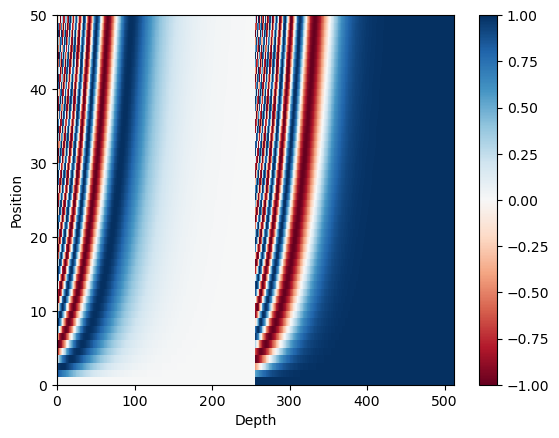

In [55]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [56]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [57]:
sample_encoder_layer = encoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_encoder_layer"
)

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file="encoder_layer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [58]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [59]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder",
)

tf.keras.utils.plot_model(sample_encoder, to_file="encoder.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [60]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [61]:
sample_decoder_layer = decoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_decoder_layer"
)

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file="decoder_layer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [62]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [63]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder",
)

tf.keras.utils.plot_model(sample_decoder, to_file="decoder.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [64]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [65]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer",
)

tf.keras.utils.plot_model(
    sample_transformer, to_file="transformer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Train model

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [66]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [67]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

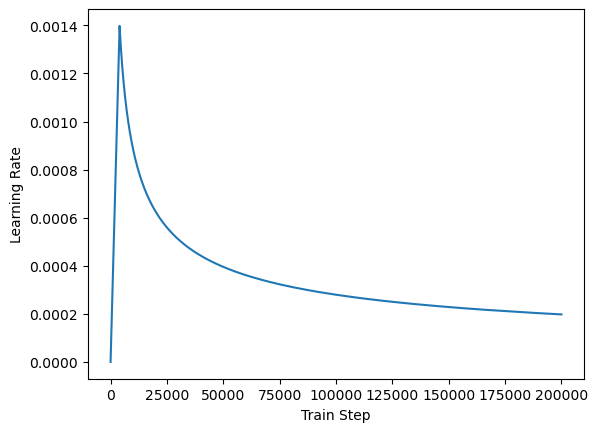

In [68]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Initialize and compile model

Initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [69]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3173632     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### Fit model

Train our transformer by simply calling `model.fit()`

In [70]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/3
690/690 [==============================] - 295s 422ms/step - loss: 2.0957 - accuracy: 0.0436
Epoch 2/3
690/690 [==============================] - 288s 418ms/step - loss: 1.4927 - accuracy: 0.0777
Epoch 3/3
690/690 [==============================] - 288s 417ms/step - loss: 1.3904 - accuracy: 0.0847


### Save and load model

In [71]:
filename = "model.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

In [72]:
del model
tf.keras.backend.clear_session()

In [73]:
model = tf.keras.models.load_model(
    filename,
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
    },
    compile=False,
)

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [74]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

Let's test our model!

In [75]:
predict("Where have you been?")

'i am not going to be a little girl .'

In [76]:
predict("It's a trap")

'i am not going to be a few years .'

In [77]:
# feed the model with its previous output
sentence = "I am not crazy, my mother had me tested."
for _ in range(5):
    print(f"Input: {sentence}")
    sentence = predict(sentence)
    print(f"Output: {sentence}\n")

Input: I am not crazy, my mother had me tested.
Output: i am not going to be a little girl .

Input: i am not going to be a little girl .
Output: i am not going to be a little girl .

Input: i am not going to be a little girl .
Output: i am not going to be a little girl .

Input: i am not going to be a little girl .
Output: i am not going to be a little girl .

Input: i am not going to be a little girl .
Output: i am not going to be a little girl .



## Summary

Here we are, we have implemented a Transformer in TensorFlow 2.0 in around 500 lines of code.

In this tutorial, we focus on the two different approaches to implement complex models with Functional API and Model subclassing, and how to incorporate them.

Try using a different dataset or hyper-parameters to train the Transformer! Thanks for reading.
